In [17]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [18]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2

In [19]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [22]:
# setting seed for PRNGs
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
tf.test.gpu_device_name()

''

# Lorenz System

In [24]:
from tools.misc_tools import create_Lorenz_data

In [25]:
# setting up params

from numpy import array

ae_idx = '000'

dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()

params_dict = eval(lines[0])

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

return_params_arr = params_dict['return_params_arr']
normalize_flag = params_dict['normalize_flag']

In [26]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [27]:
n = len(boundary_idx_arr)
# # '''
# num_cols = 1
# num_rows = n

# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

# prev_idx = 0
# for i in range(n):
#     # ax = plt.axes(projection ='3d')
#     next_idx = boundary_idx_arr[i]
    
#     ax_orig = fig.add_subplot(num_rows, num_cols, i+1, projection ='3d')
#     ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
#     ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:]))
#     ax_orig.set_xlabel('x')
#     ax_orig.set_ylabel('y')
#     ax_orig.set_zlabel('z')
    
#     # ax_predict = fig.add_subplot(num_rows, num_cols, 2*i+2, projection ='3d')
#     # ax_predict.plot(reconstructed_data[prev_idx:next_idx, 0], reconstructed_data[prev_idx:next_idx, 1], reconstructed_data[prev_idx:next_idx, 2])
#     # ax_predict.title.set_text(r'NN Reconstructed Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
#     # )
#     # ax_predict.set_xlabel('x')
#     # ax_predict.set_ylabel('y')
#     # ax_predict.set_zlabel('z')

#     prev_idx = next_idx
# # '''

# Autoencoder

In [28]:
# setting up data
train_split = 0.9
test_split = 1 - train_split
val_split = 0.1  # to be used later on;
                 # `val_split` of total data will
                 # be taken out of `training_data`
                 # to use as validation data.

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round(train_split*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
test_data = all_data[idx[boundary:], :]

train_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [29]:
from tools.ae_v3 import Autoencoder

In [30]:
# Training parameters
learning_rate_list = [0.001, 0.0001, 0.00001]
epochs = 2000
patience = 100  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
lambda_reg = 1e-5  # weight for regularizer

# Initialize network
ae_net = Autoencoder(
    data_dim=6,
    enc_layers=[16,12,8,8,4,4,2],
    dec_layers=[2,4,4,8,8,12,16],
    latent_space_dim=2,
    lambda_reg=lambda_reg,
    reg_name='L2',
    enc_layer_act_func='elu',
    enc_final_layer_act_func='tanh',
    dec_layer_act_func='elu',
    dec_final_layer_act_func='linear',
    load_file=None)

In [31]:
ae_net.load_weights(dir_name_ae+dir_sep+'checkpoints'+dir_sep+'checkpoint')

In [32]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError()
)

# implementing early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=True,
    min_delta=min_delta
)

# time callback for each epoch
class mytimecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.total_time = 0
        self.start_time = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.total_time = time.time() - self.start_time
        print(' - tot_time: {:.0f}h {:.0f}m {:.1f}s'.format(self.total_time//3600, (self.total_time//60)%60, self.total_time%60))
#     def on_train_end(self,logs = {}):
#         plt.xlabel('Epoch')
#         plt.ylabel('Total time taken until an epoch in seconds')
#         plt.plot(*zip(*self.times))
#         plt.show()
timekeeper_cb = mytimecallback()

# model checkpoint callback
dir_name_ckpt = dir_name_ae+'/checkpoints'
if not os.path.isdir(dir_name_ckpt):
    os.makedirs(dir_name_ckpt)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    verbose=2,
    save_weights_only=True,
    period=5
)

# training the network
val_loss_hist = []
train_loss_hist = []
lr_change=[0]
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    K.set_value(ae_net.optimizer.lr, learning_rate)

    total_s_len = 80
    sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
    print('\n\n' + '-'*len(sep_lr_s))
    print('\n' + sep_lr_s+'\n')
    print('-'*len(sep_lr_s) + '\n\n')
    
    history = ae_net.fit(training_data, training_data,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])
    
    lr_change.append(lr_change[i]+len(history.history['val_loss']))

Streaming output truncated to the last 5000 lines.
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 13/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 14/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 15/2000
 998/1001 [============================>.] - ETA: 0s - loss: 0.0024 - tot_time: 0h 0m 47.8s

Epoch 15: val_loss did not improve from 0.00247
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 16/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 17/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 18/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 19/2000
1001/1001 [==============================] - 3s 3ms/step - loss: 0.0025 -

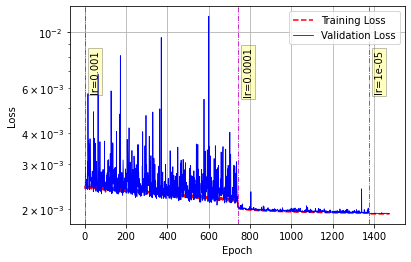

In [33]:
# plotting losses

# Get training and test loss histories
training_loss = train_loss_hist
val_loss = val_loss_hist

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# lr_change = [0, 987, 987+334]
# for i in range(1,len(lr_change)):
#     lr_change[i] += lr_change[i-1]

# Visualize loss history
plt.semilogy(epoch_count, training_loss, 'r--')
plt.semilogy(epoch_count, val_loss, 'b-', linewidth=0.8)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
for i in range(len(lr_change)-1):
    plt.axvline(lr_change[i], color='m', linestyle='-.', linewidth=0.8)
    plt.text(
        lr_change[i]+plt.gca().transData.inverted().transform(plt.gca().transAxes.transform([0.06, 0.7]))[0],
        plt.gca().transData.inverted().transform(plt.gca().transAxes.transform([0.5, 0.7]))[1],
        'lr={}'.format(learning_rate_list[i]),
        rotation=90,
        verticalalignment='center',
        horizontalalignment='left',
        bbox=dict(facecolor='yellow', alpha=0.25, boxstyle='square,pad=0.2')
    )
plt.savefig(dir_name_ae+'/plots/loss_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
reconstructed_data = ae_net.predict(all_data)

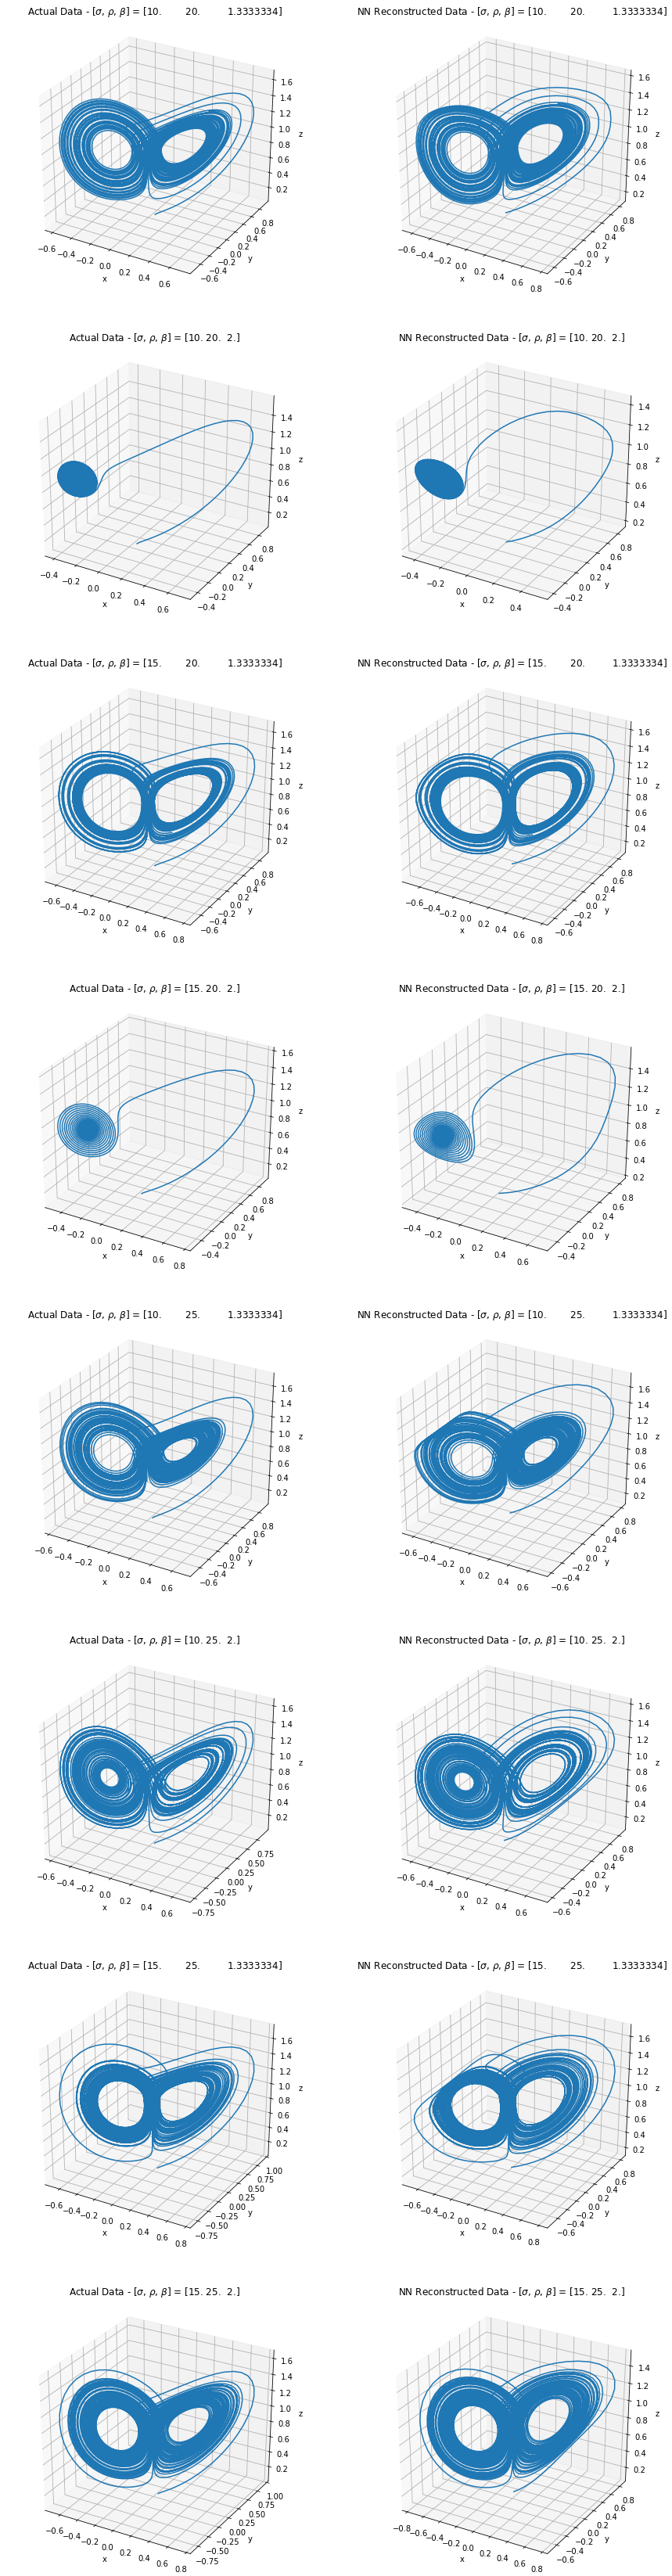

In [35]:
n = len(boundary_idx_arr)
num_cols = 2
num_rows = n

# plt.ion()

fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

prev_idx = 0
for i in range(n):
    # ax = plt.axes(projection ='3d')
    next_idx = boundary_idx_arr[i]
    
    ax_orig = fig.add_subplot(num_rows, num_cols, 2*i+1, projection ='3d')
    ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
    ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:]))
    ax_orig.set_xlabel('x')
    ax_orig.set_ylabel('y')
    ax_orig.set_zlabel('z')
    
    ax_predict = fig.add_subplot(num_rows, num_cols, 2*i+2, projection ='3d')
    ax_predict.plot(reconstructed_data[prev_idx:next_idx, 0], reconstructed_data[prev_idx:next_idx, 1], reconstructed_data[prev_idx:next_idx, 2])
    ax_predict.title.set_text(r'NN Reconstructed Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
    )
    ax_predict.set_xlabel('x')
    ax_predict.set_ylabel('y')
    ax_predict.set_zlabel('z')

    prev_idx = next_idx

# fig.savefig(dir_name_ae+'/reconstructed_data.png', dpi=300, bbox_inches='tight')

In [36]:
# saving reconstructed data
n = len(boundary_idx_arr)
num_cols = 2
num_rows = 1

# plt.ion()

# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

recon_data_dir = dir_name_ae+'/plots/reconstructed_data'
os.makedirs(recon_data_dir)

num_digits_n = int(np.log10(n)+1)

prev_idx = 0
for i in range(n):
    fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))
    # ax = plt.axes(projection ='3d')
    next_idx = boundary_idx_arr[i]
    
    ax_orig = fig.add_subplot(num_rows, num_cols, 1, projection ='3d')
    ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
    ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:]))
    ax_orig.set_xlabel('x')
    ax_orig.set_ylabel('y')
    ax_orig.set_zlabel('z')
    
    ax_predict = fig.add_subplot(num_rows, num_cols, 2, projection ='3d')
    ax_predict.plot(reconstructed_data[prev_idx:next_idx, 0], reconstructed_data[prev_idx:next_idx, 1], reconstructed_data[prev_idx:next_idx, 2])
    ax_predict.title.set_text(r'NN Reconstructed Data - [$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', ')
    )
    ax_predict.set_xlabel('x')
    ax_predict.set_ylabel('y')
    ax_predict.set_zlabel('z')

    prev_idx = next_idx
    
    fig.savefig(recon_data_dir+'/reconstructed_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
#     fig.close()
    plt.close()

In [37]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

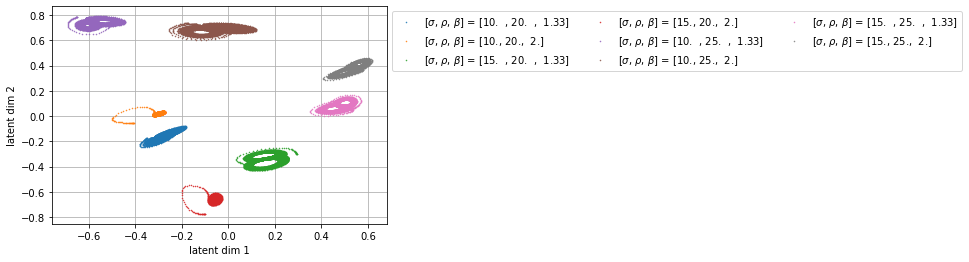

In [38]:
# plotting latent states
prev_idx = 0
# plt_idx = 27
# for i in range(plt_idx,plt_idx+1):
for i in range(len(boundary_idx_arr)):
    next_idx = boundary_idx_arr[i]
    plt.plot(
        latent_states_all[prev_idx:next_idx, 0],
        latent_states_all[prev_idx:next_idx, 1],
        linewidth=0,
        marker='.',
        color='C'+str(i),
        markersize=1,
#         label=r'[$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
        label=r'[$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', ')
    )
    prev_idx = next_idx

# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.grid(True)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.legend(bbox_to_anchor=(1,1), ncol=3)
plt.savefig(dir_name_ae+'/plots/latent_space.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# ae_net.summary()

In [40]:
save_path = dir_name_ae+dir_sep+'final_net'

if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(save_path+dir_sep+'losses.txt', 'w') as f:
    f.write(str({
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'lr_change':lr_change
    }))

ae_net.save_everything(file_name=save_path+dir_sep+'final_net')

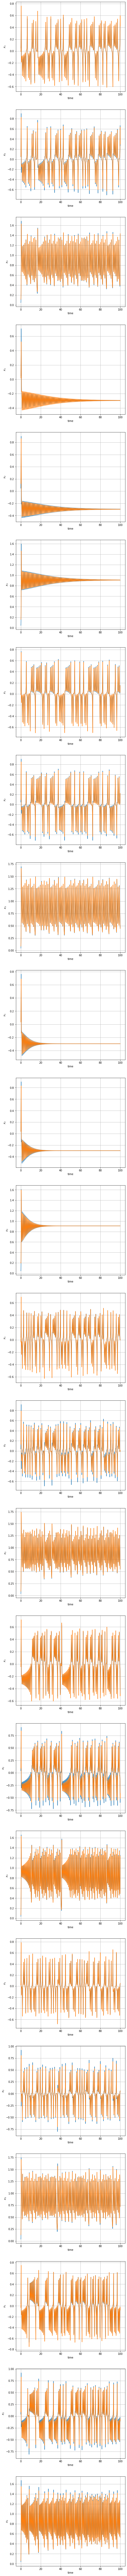

In [41]:
n = len(boundary_idx_arr)
num_cols = 1
num_rows = 3*n

# plt.ion()

fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

Tt = N * delta_t
time_arr = np.arange(0, N+1) * Tt / N

y_labels = [r'$x_1$', r'$x_2$', r'$x_3$']

prev_idx = 0
for i in range(n):
    # ax = plt.axes(projection ='3d')
    next_idx = boundary_idx_arr[i]

    for j in range(3):
        ax = fig.add_subplot(num_rows, num_cols, 3*i+j+1)
        ax.plot(time_arr, all_data[prev_idx:next_idx, j], label='original')
        ax.plot(time_arr, reconstructed_data[prev_idx:next_idx, j], label='reconstructed')
        ax.set_ylabel(y_labels[j])
        ax.set_xlabel('time')
        ax.grid(True)


    prev_idx = next_idx

# LSTM